In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
train_split = 0.8

def data_splits(X, Y, train_split):
    N = len(X)
    indeces = np.arange(N)
    np.random.shuffle(indeces)

    N_train = round(N*train_split)

    # get the first N_train for the train split (but now they are random)
    train_idx = indeces[:N_train]
    # the rest are for test split
    test_idx = indeces[N_train:]

    # slice the original datasets with an index array
    X_train = X[train_idx]  
    Y_train = Y[train_idx]
    
    X_test = X[test_idx]
    Y_test = Y[test_idx]

    # put in tuples the two splits
    return X_train, Y_train, X_test, Y_test

In [3]:
# User selection
K = 3
a, b = -5, 5
N = 50
var = 0.5

In [4]:
theta_true = np.ones(K)
X = np.linspace(a, b, N)
X.shape

(50,)

In [5]:
def generalized_vandermonde_matrix(func_list, X):
    K = len(func_list)
    N = len(X)
    matrix = np.zeros((N, K))
    for i, func in enumerate(func_list):
        matrix[:, i] = func(x=X)
    return matrix

def phi(j, x):
    return np.power(x, j)

def get_normal_vandermonde(K, X):
    vander = generalized_vandermonde_matrix(
        func_list=[partial(phi, j=j) for j in range(K)],
        X=X
    )
    return vander

In [6]:
vander = get_normal_vandermonde(K, X)

Y = vander @ theta_true + np.random.normal(0, np.sqrt(var), size=len(X))
Y.shape

(50,)

In [7]:
X_train, Y_train, X_test, Y_test = data_splits(X, Y, train_split)

In [8]:
def MLE_normal_equations(vander, Y):
    return np.linalg.inv(vander.T @ vander) @ vander.T @ Y

In [9]:
def loss(vander, Y, theta):
    N = len(Y)
    tmp = (vander @ theta) - Y
    return (tmp.T @ tmp)/N

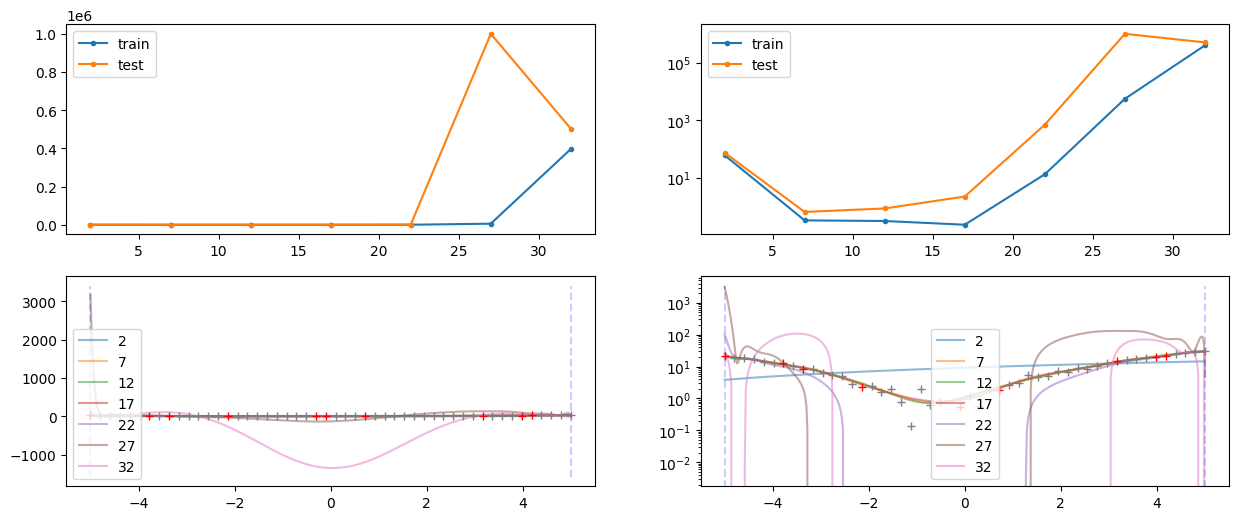

In [10]:
_, axs = plt.subplots(2, 2, figsize=(15,6))

axs = axs.flatten()

x_plot = np.linspace(a, b, N*10)
k_range = range(2, 33, 5)

train_accuracy = []
test_accuracy = []

for k in k_range:
    vander_train = get_normal_vandermonde(k, X_train)
    theta_MLE = MLE_normal_equations(vander_train, Y_train)
    train_accuracy.append(loss(vander_train, Y_train, theta_MLE))

    vander_test = get_normal_vandermonde(k, X_test)
    test_accuracy.append(loss(vander_test, Y_test, theta_MLE))

    axs[2].plot(x_plot, get_normal_vandermonde(k, x_plot) @ theta_MLE, label="{}".format(k), alpha=0.5)
    axs[3].plot(x_plot, get_normal_vandermonde(k, x_plot) @ theta_MLE, label="{}".format(k), alpha=0.5)


axs[0].plot(k_range, train_accuracy, marker=".", label = "train")
axs[0].plot(k_range, test_accuracy, marker=".", label = "test")
axs[0].legend()

axs[1].plot(k_range, train_accuracy, marker=".", label = "train")
axs[1].plot(k_range, test_accuracy, marker=".", label = "test")
axs[1].legend()
axs[1].set_yscale("log")

axs[2].vlines([a, b], axs[2].get_ylim()[0], axs[2].get_ylim()[1], colors="b", linestyles="dashed", alpha=0.2)
axs[2].plot(X_train, Y_train, "+")
axs[2].plot(X_test, Y_test, "+r")
axs[2].legend()

axs[3].vlines([a, b], axs[3].get_ylim()[0], axs[3].get_ylim()[1], colors="b", linestyles="dashed", alpha=0.2)
axs[3].plot(X_train, Y_train, "+")
axs[3].plot(X_test, Y_test, "+r")
axs[3].legend()
axs[3].set_yscale("log")

plt.show()


There are some problems with the fact that the polynomials diverge around the edge of the interval. This is normal for polynomial regression, because, expecially with higher powers of x, the terms explode quickly. Moreover, if, as in this case, the data split procedure caused one of the edge points to be in the test set, this would be completely missed by the higher degree polynomials and would cause a big test error.

However, it is indeed strange that the training error increases. This could be caused by the ill-conditioning of the vander matrix, which we saw in homework 1. 

Since the Normal Equations are $(\Phi^T \Phi)^{-1} \Phi^T \theta$, probably some numerical errors cause the more free and complex higher degree polynomial to miss training data, and the errors are exacerbated by the big powers of x (meaning that a small error causes a big loss).

So we try to restrict the polynomials to a maximum ~10 degree, and we recreate the data_splits in order to have X_train equispaced in $[a, b]$ and X_test randomly placed in $[a, b]$ instead.

In [ ]:
def create_new_data(N, a, b, train_split, K):
    
    N_train = round(N * train_split)
    X_train = np.linspace(a, b, N_train)
    X_test = np.random.random(N-N_train)

    # should I do this on X or X_train??????
    theta_true = np.ones(K)
    vander = get_normal_vandermonde(K, X_train)
    Y = vander @ theta_true + np.random.normal(0, np.sqrt(var), size=len(X))
